No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


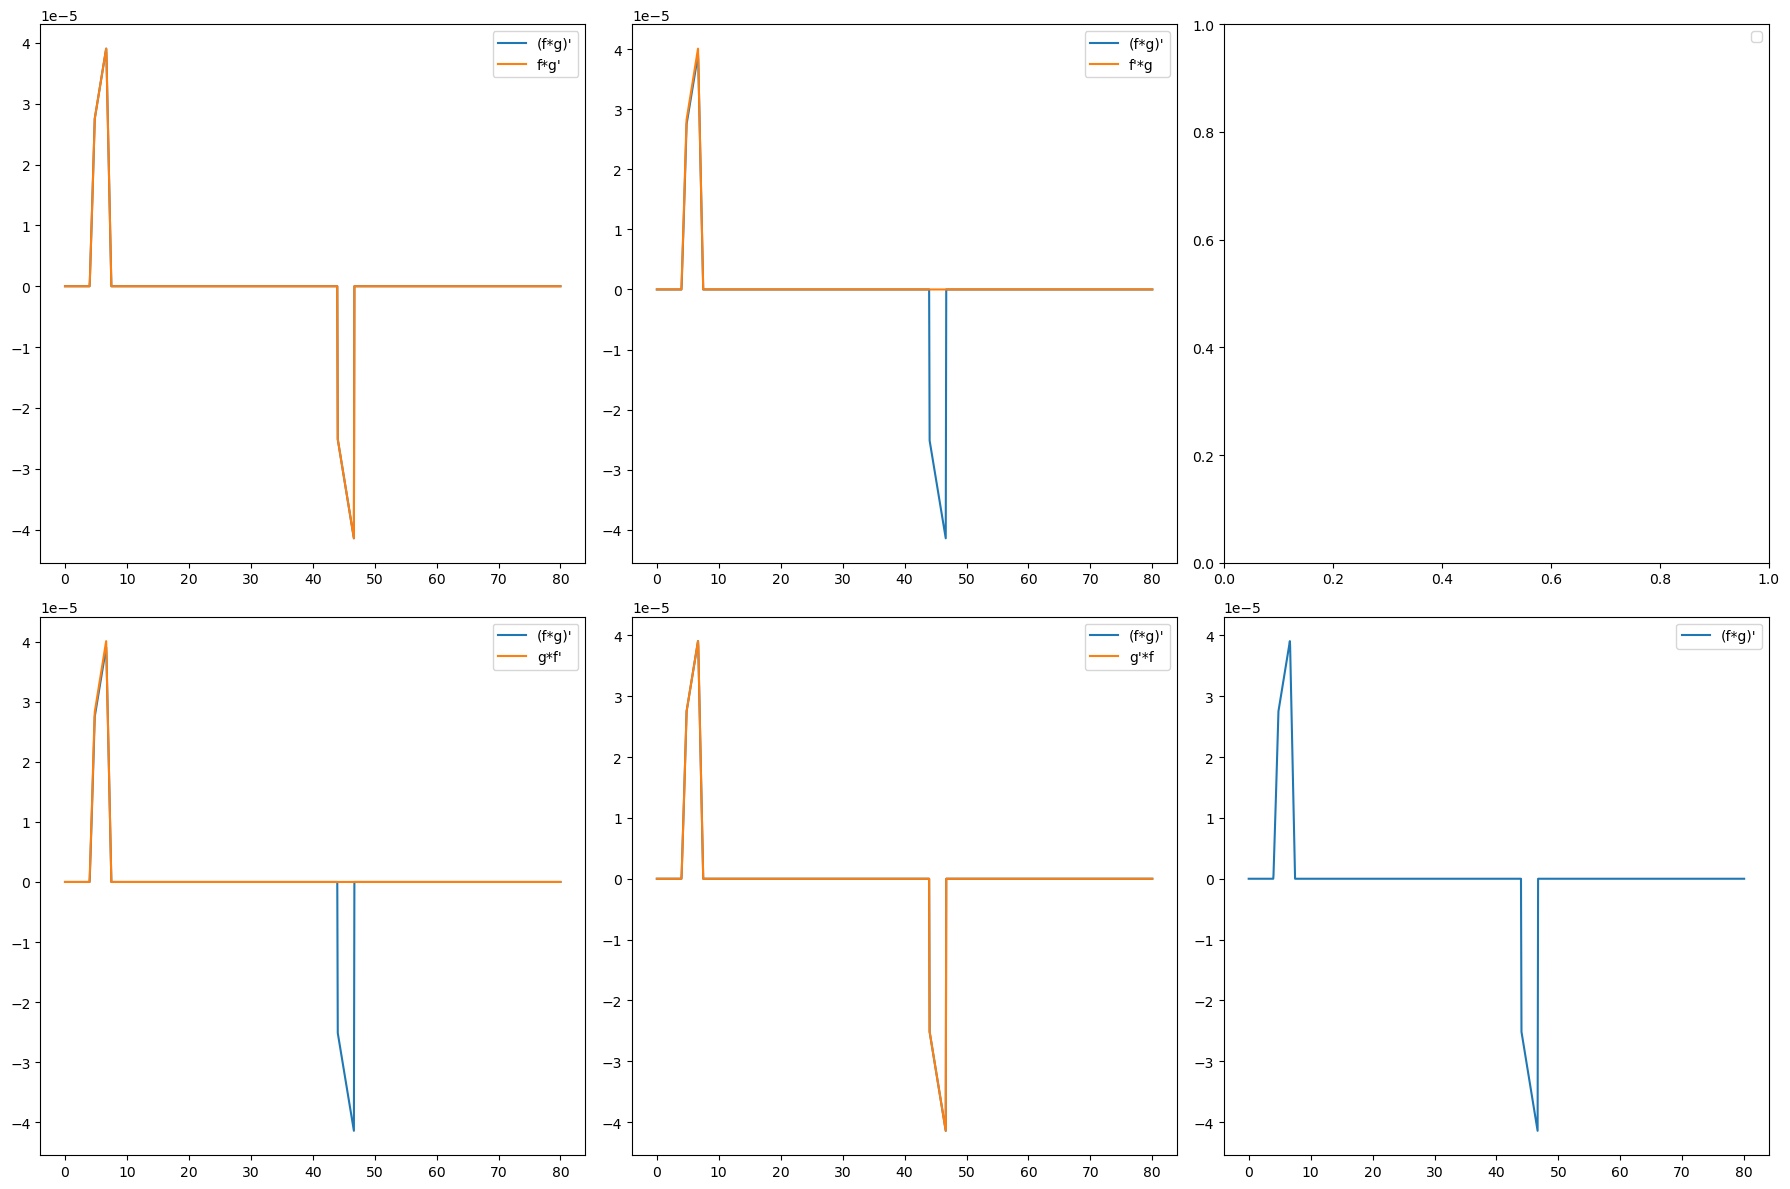

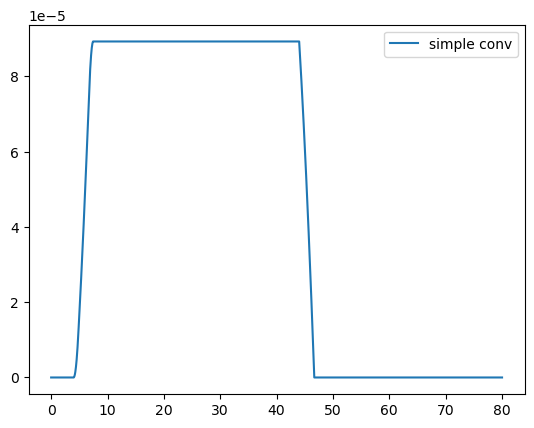

In [227]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    result = np.zeros_like(t)
    mask1 = (0 <= t) & (t < 1)
    mask2 = t >= 1
    result[mask1] = t[mask1]
    result[mask2] = 1
    return result

def g(x):
    return x * (np.heaviside(x - r /alpha, 1) - np.heaviside(x -  r / beta, 1))/r**4

# xの範囲と微小変化を定義
x = np.linspace(0, 40, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロット
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 80, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.legend()
plt.show()

plt.plot(x_full, conv, label = "simple conv")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


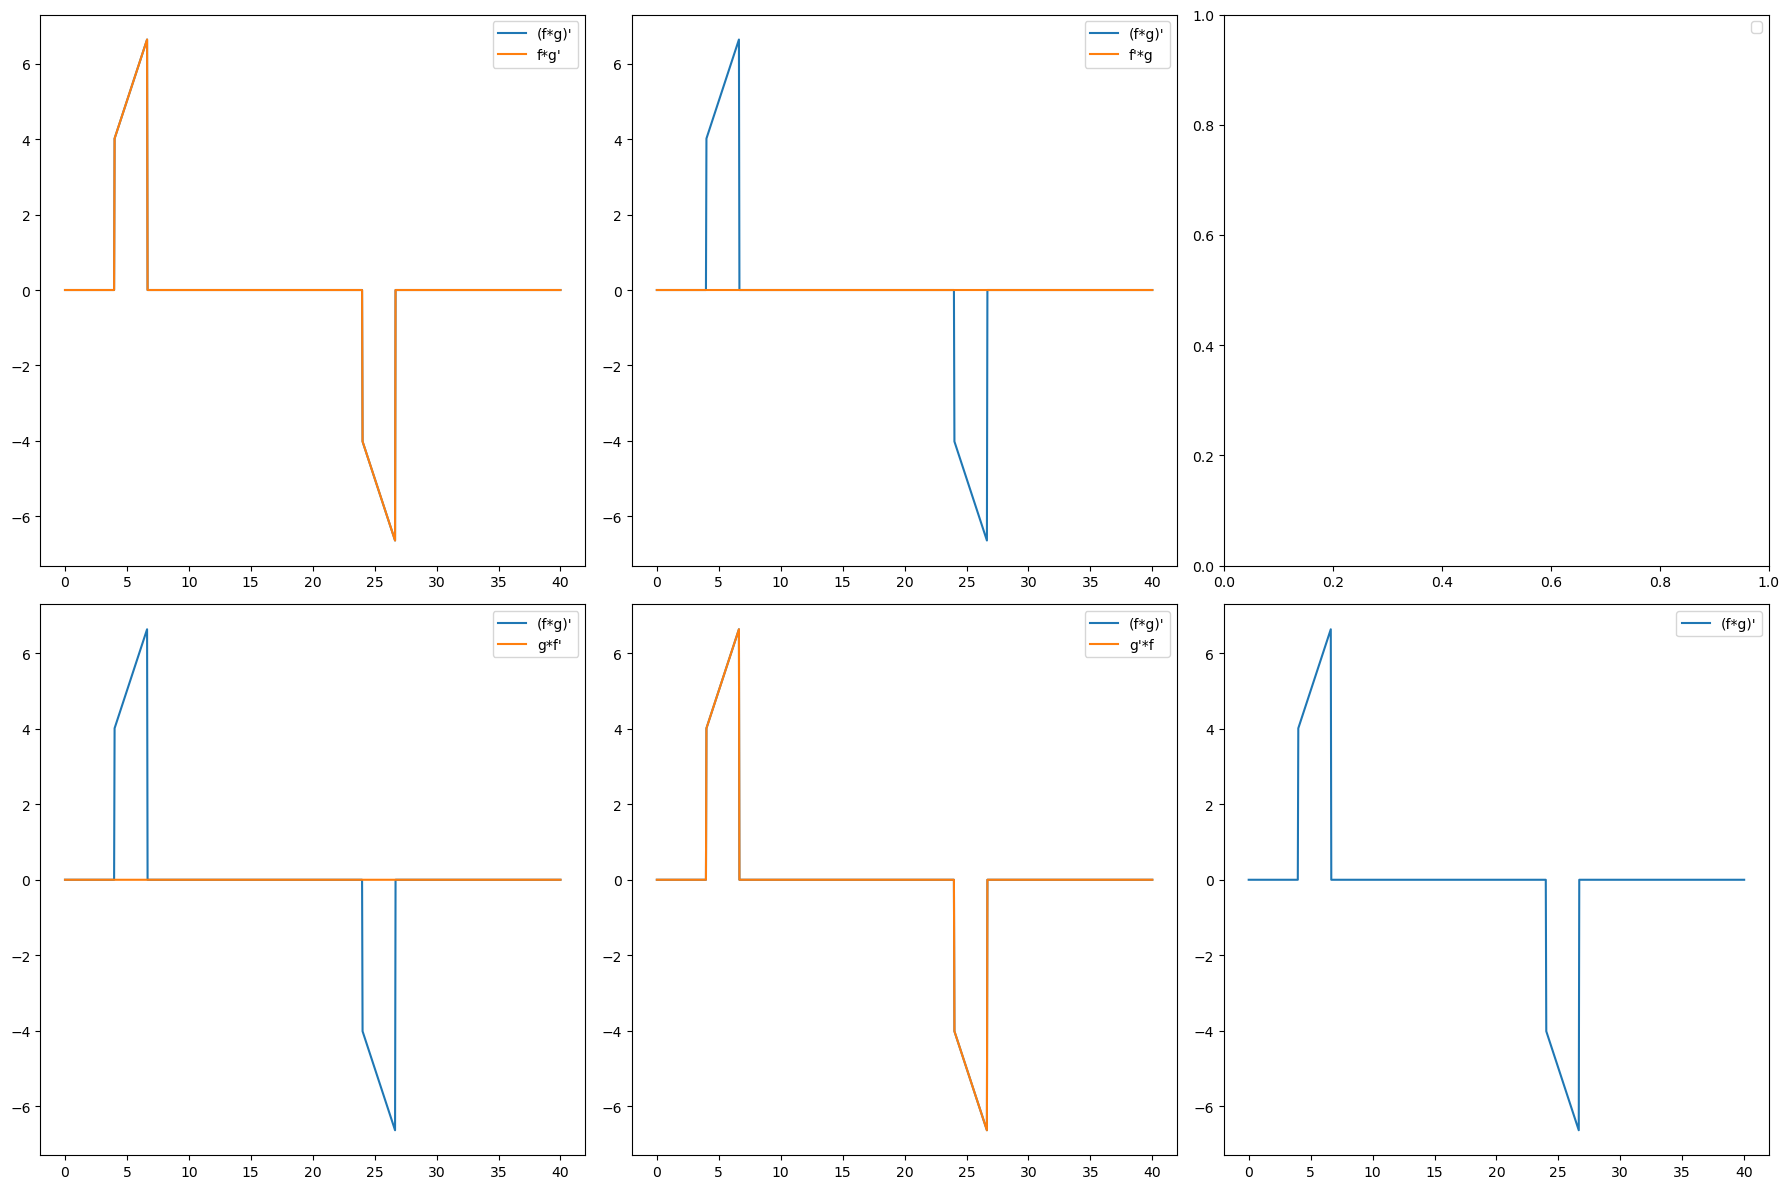

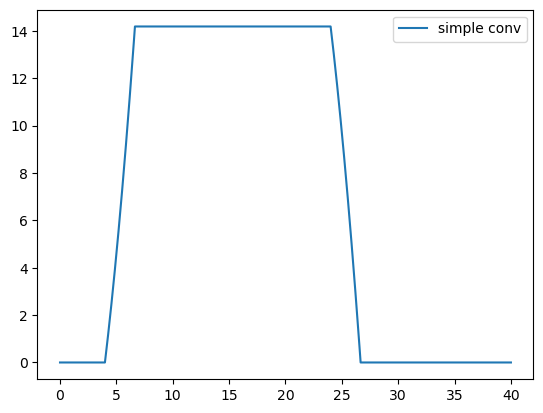

In [228]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x):
    return x * (np.heaviside(x - r /alpha, 1) - np.heaviside(x -  r / beta, 1))

# xの範囲と微小変化を定義
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロット
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.legend()
plt.show()

plt.plot(x_full, conv, label = "simple conv")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


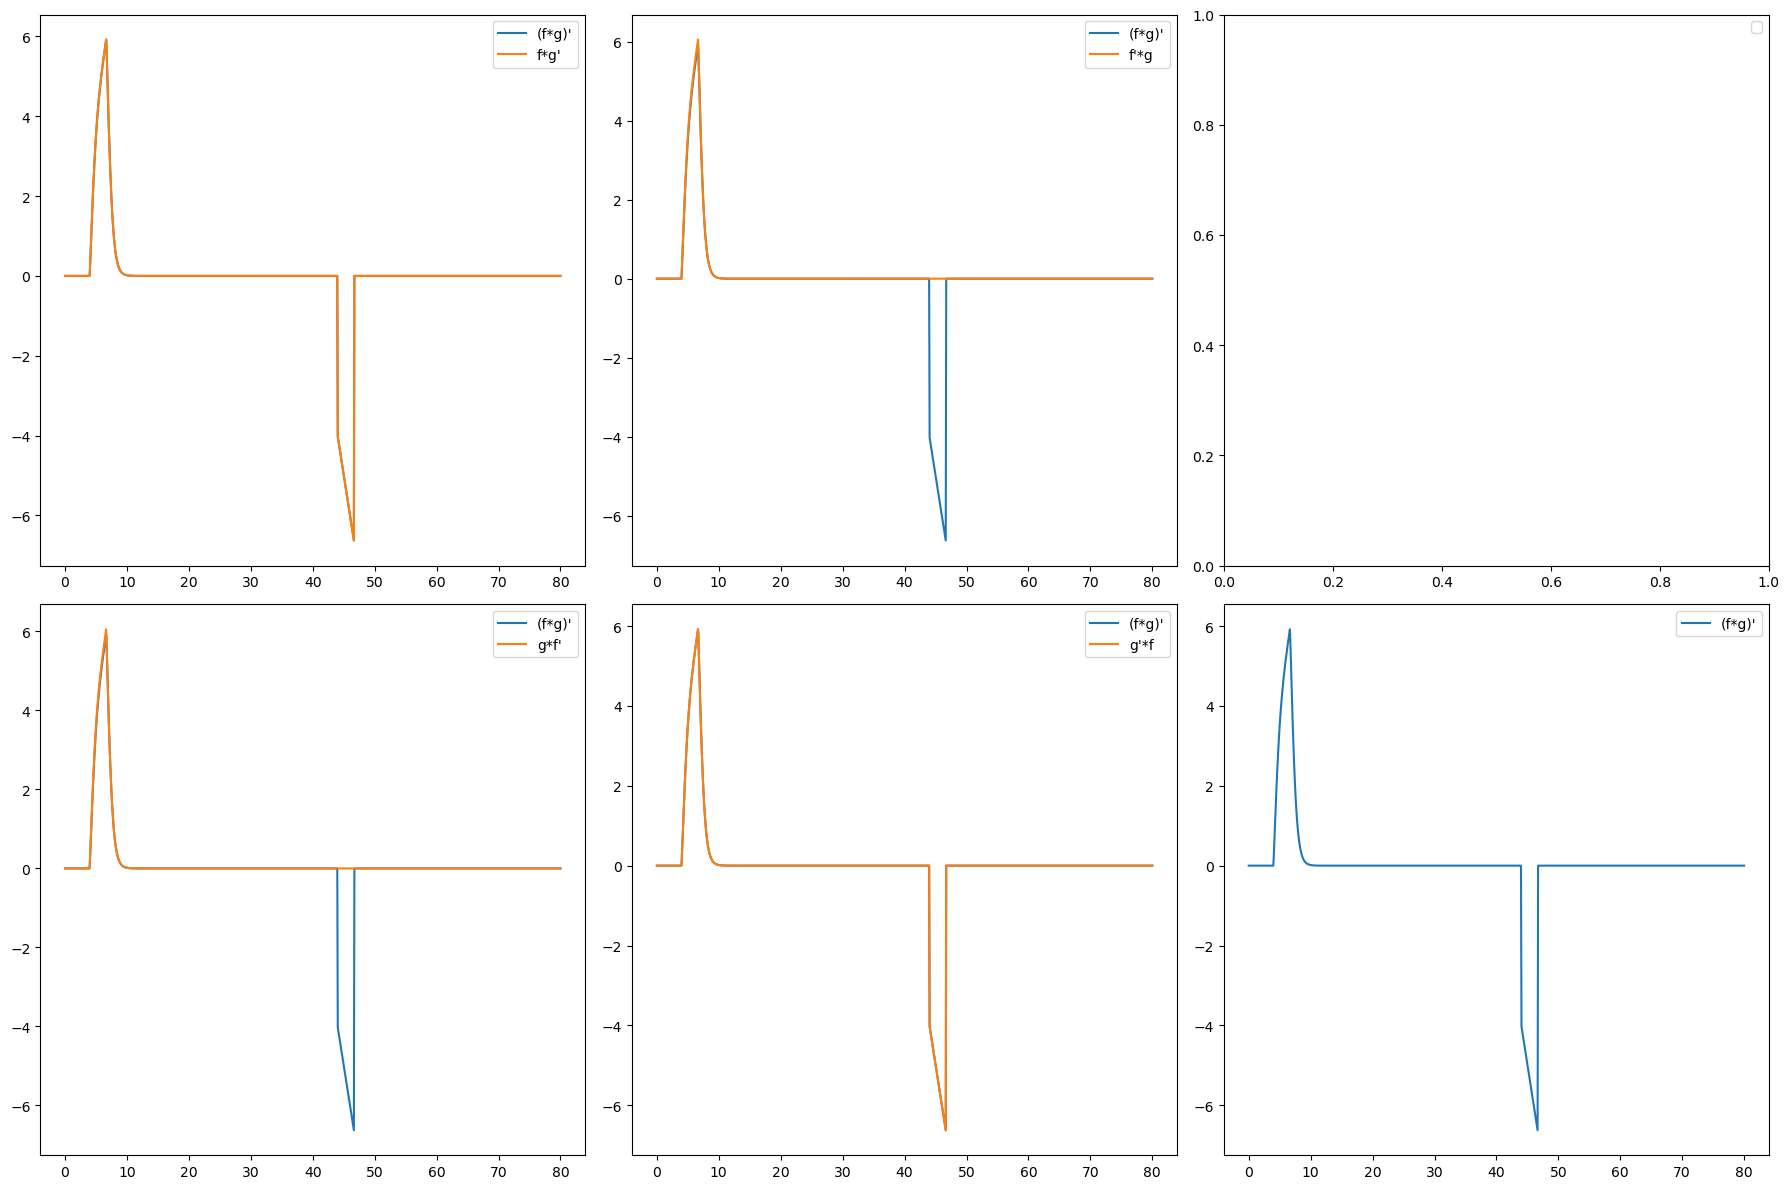

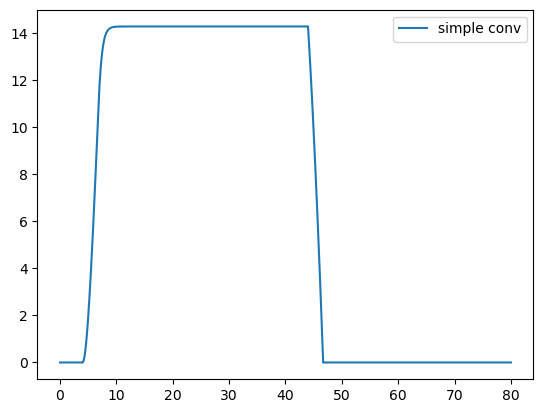

In [195]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.tanh(x)

def g(x):
    return x * (np.heaviside(x - r /alpha, 1) - np.heaviside(x -  r / beta, 1))

# xの範囲と微小変化を定義
x = np.linspace(0, 40, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロット
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 80, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.legend()
plt.show()

plt.plot(x_full, conv, label = "simple conv")
plt.legend()
plt.show()


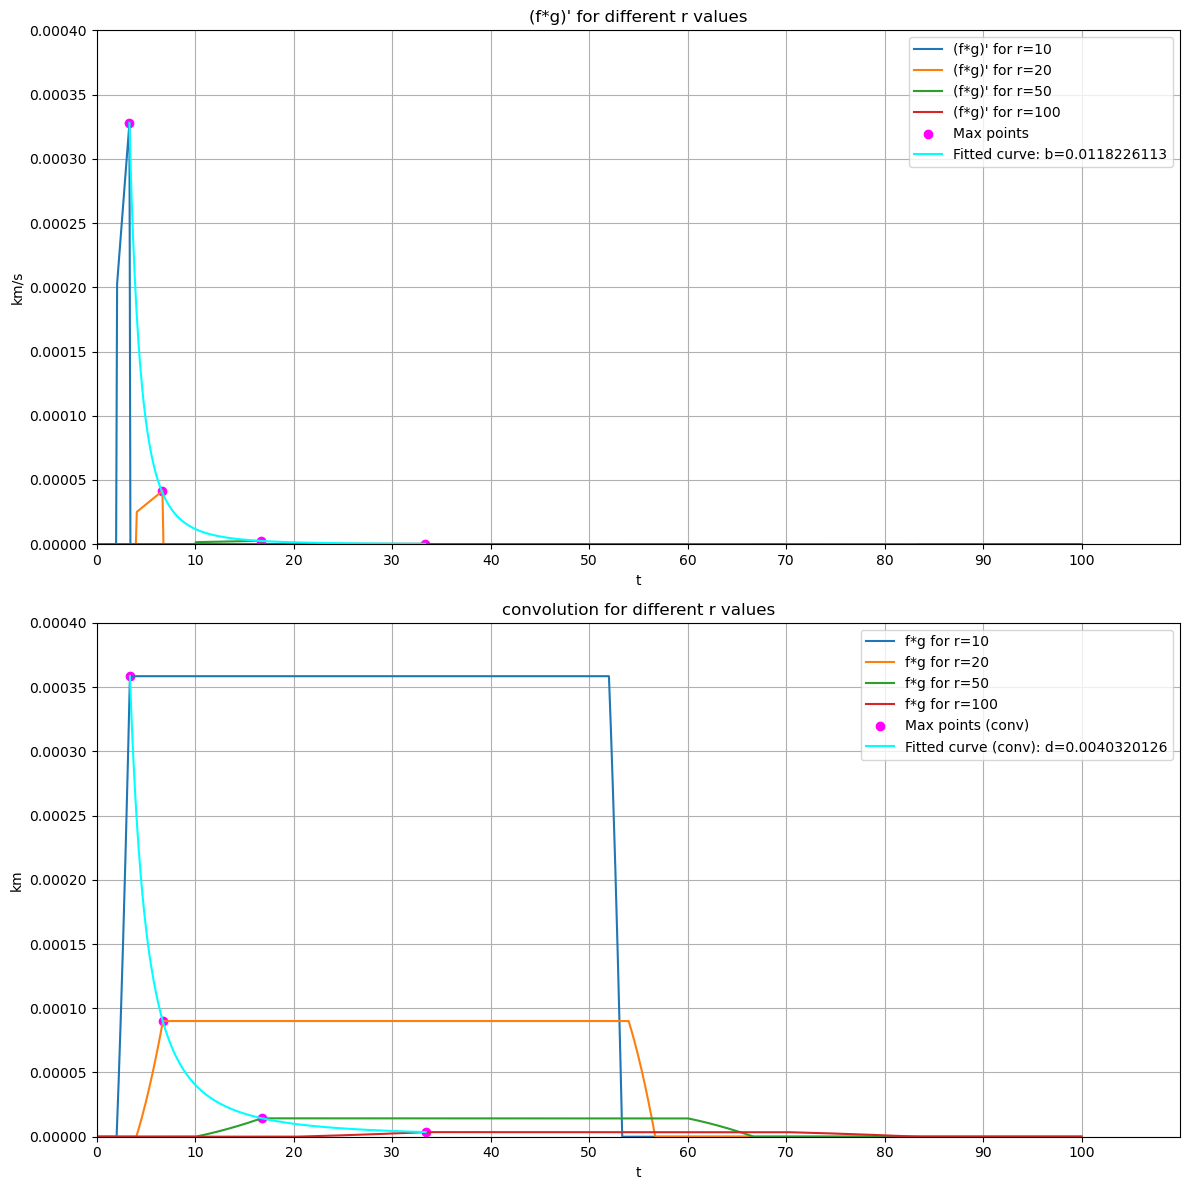

In [234]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 畳み込む関数
def f(t):
    return np.heaviside(t, 0)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 0) - np.heaviside(t - r / beta, 0)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))


plt.tight_layout()
plt.show()


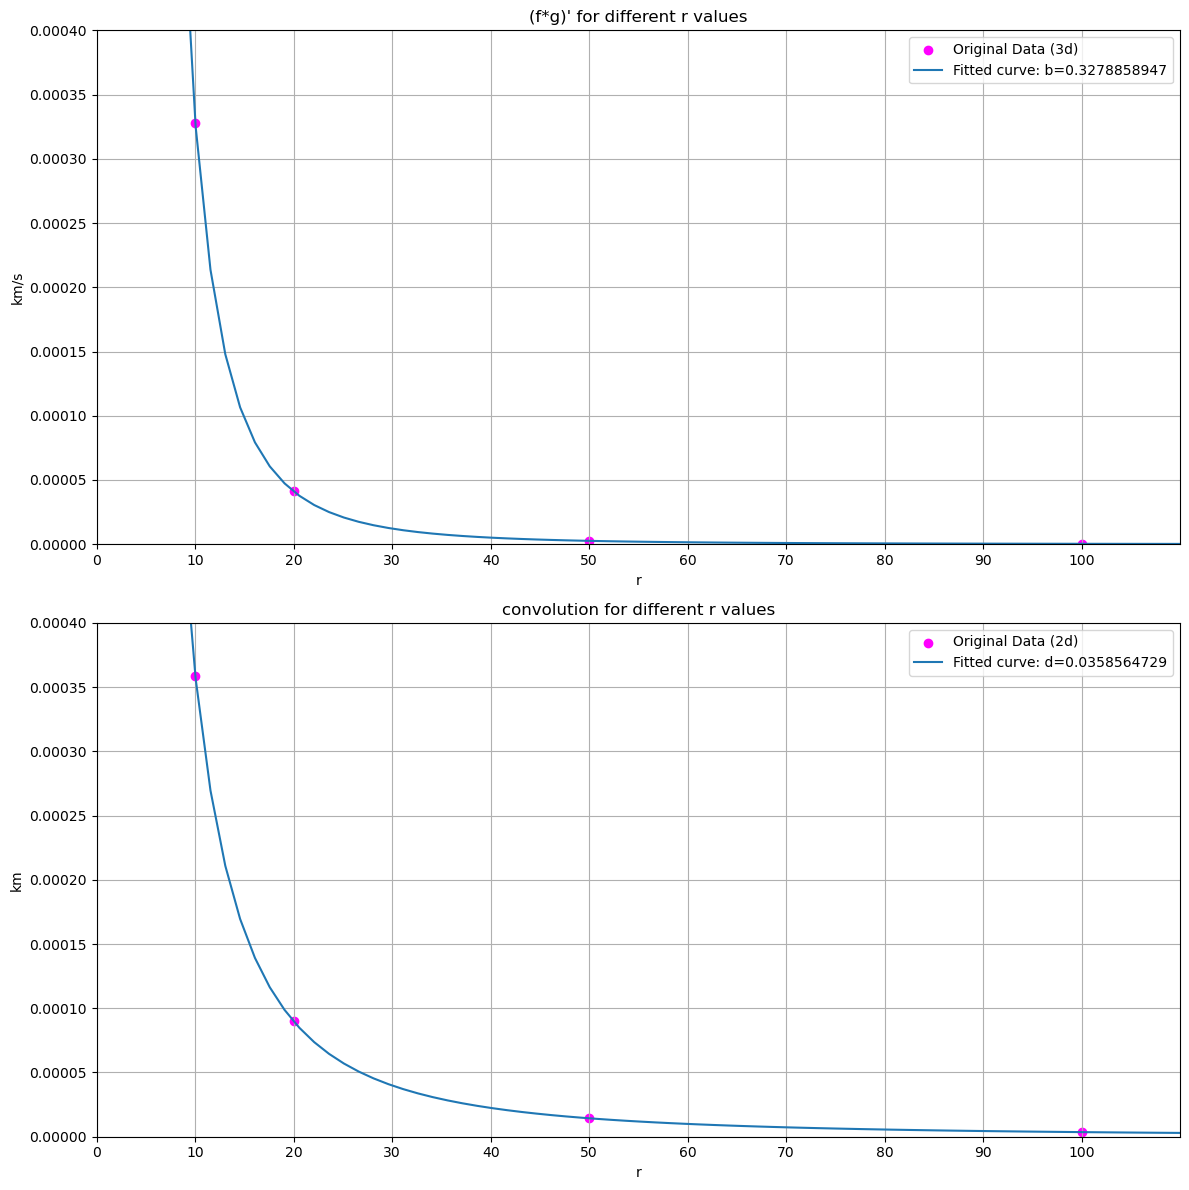

In [235]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
#r_values_dense = np.linspace(min(r_values), max(r_values), 100)   # 密なxの範囲を生成
r_values_dense = np.linspace(1, 150, 100)

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()

/var/folders/58/_f3bywg95116dv_3jb9q54840000gn/T/ipykernel_7015/857350065.py:41: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d_conv = misc.derivative(lambda x: np.interp(x, t_full, conv), t_full, dx=dt)


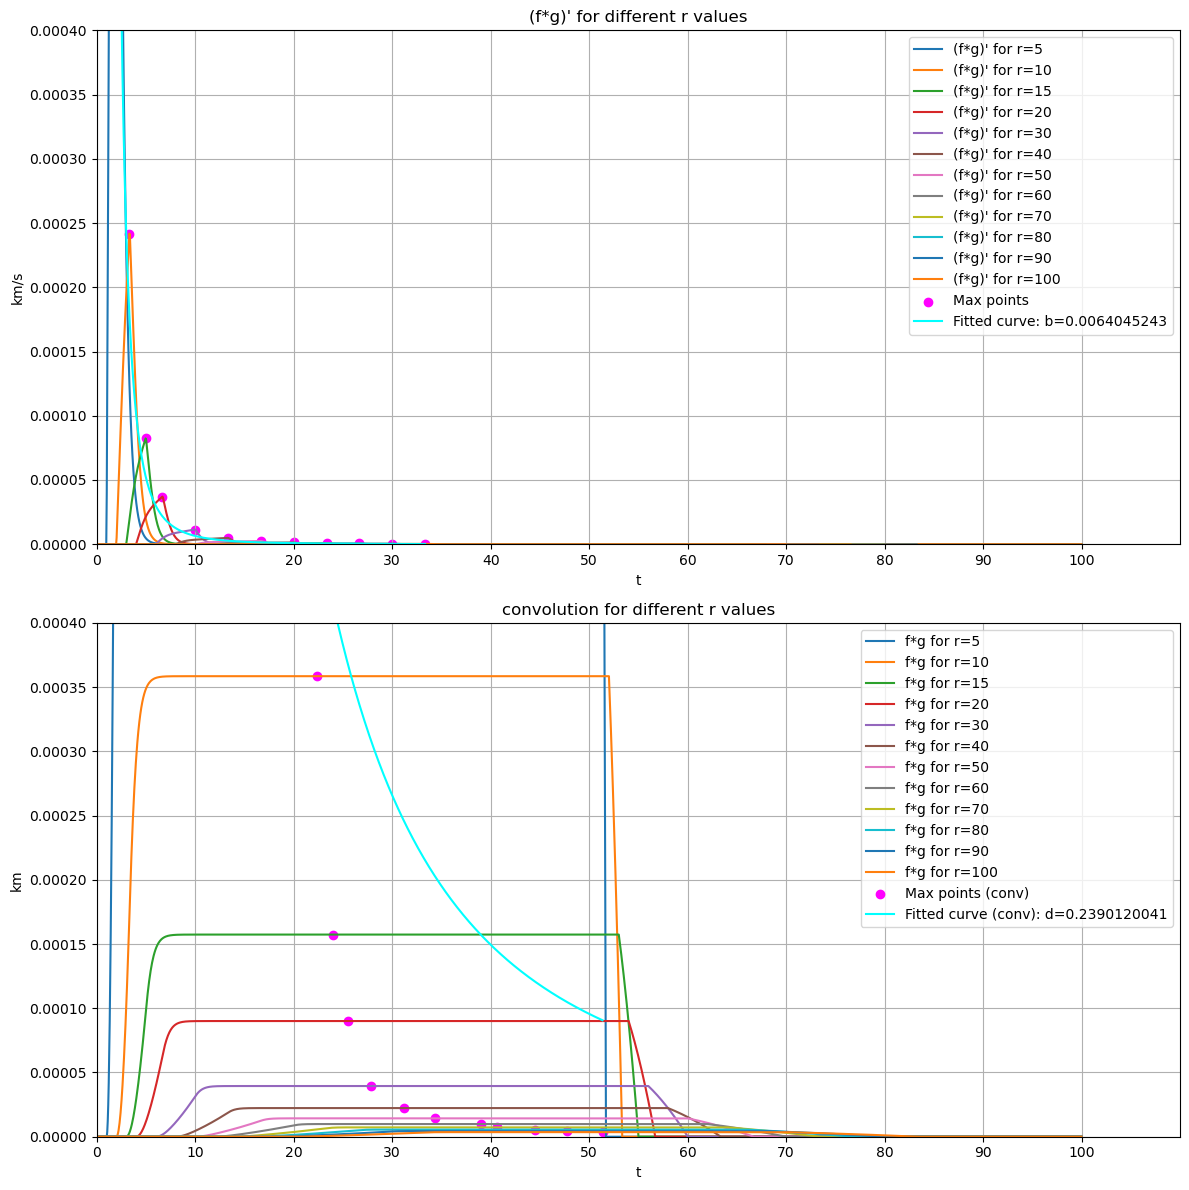

In [210]:
import numpy as np
from scipy import signal, misc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# 畳み込む関数
def f(t):
    return np.tanh(t)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 0) - np.heaviside(t - r / beta, 0)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = misc.derivative(lambda x: np.interp(x, t_full, conv), t_full, dx=dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)

    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()


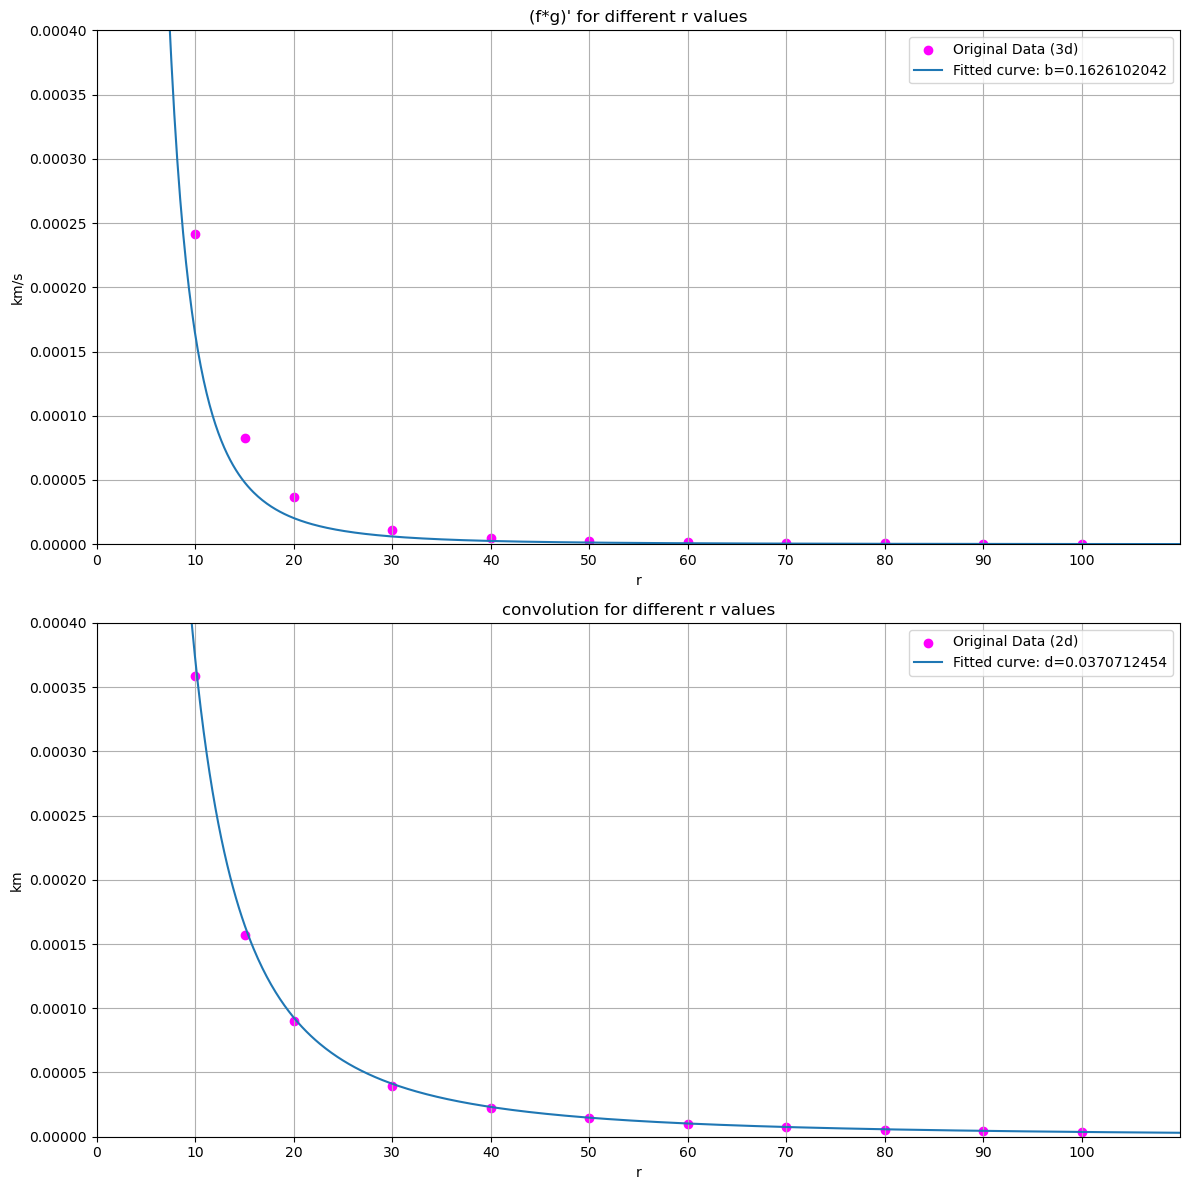

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
#r_values_dense = np.linspace(min(r_values), max(r_values), 100)   # 密なxの範囲を生成
r_values_dense = np.linspace(1, 150, 1000)

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()

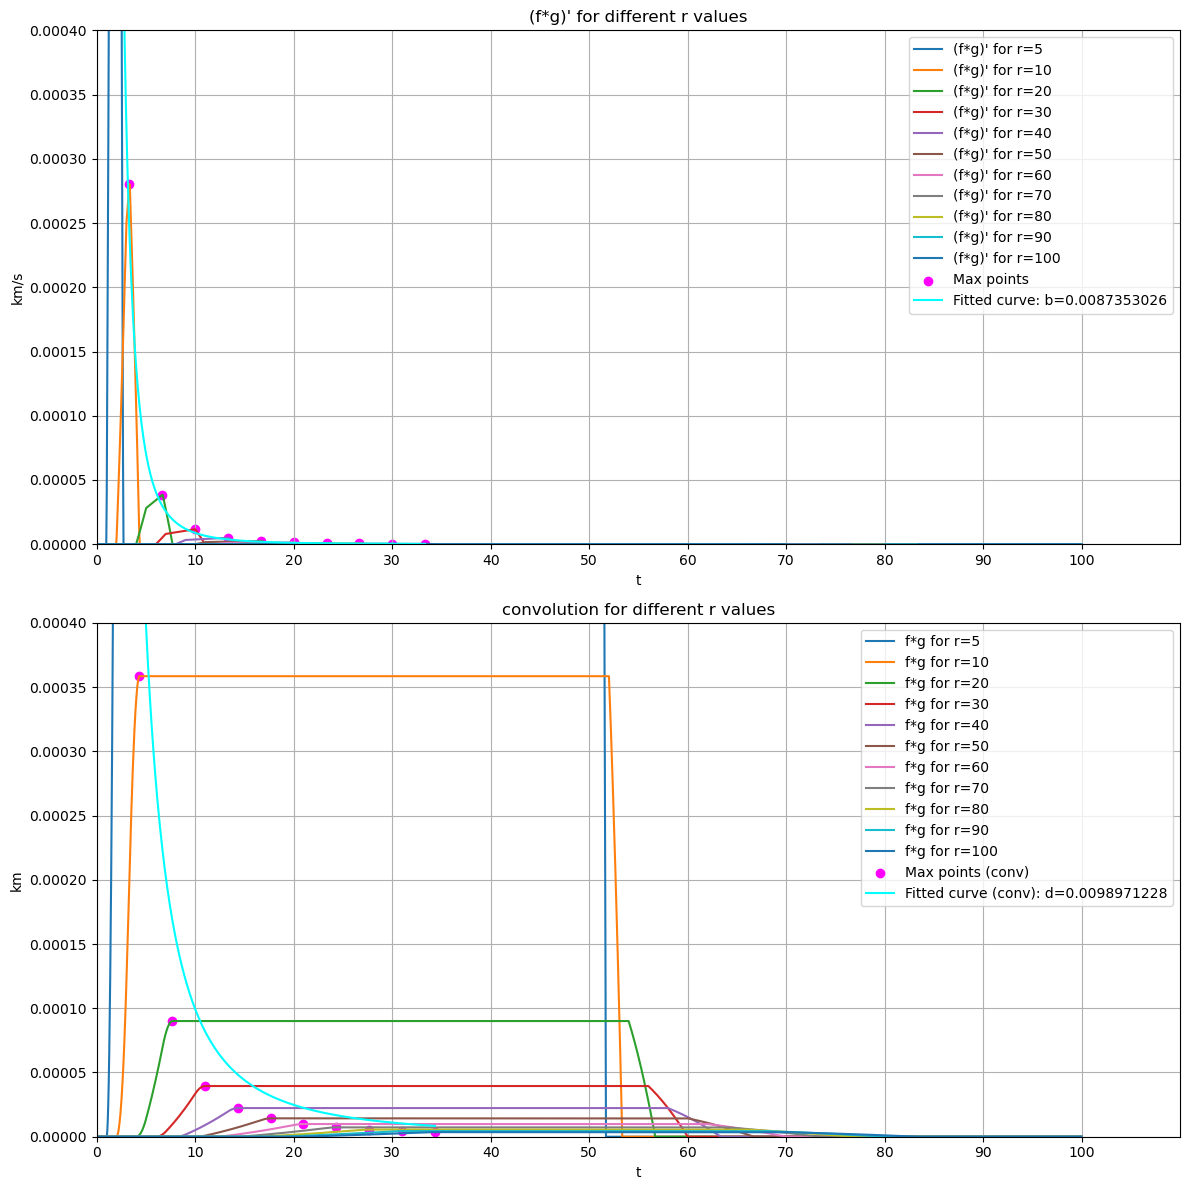

In [212]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [5,10, 20,30,40, 50, 60,70,80,90,100]

# 畳み込む関数
def f(t):
    result = np.zeros_like(t)
    mask1 = (0 <= t) & (t < 1)
    mask2 = t >= 1
    result[mask1] = t[mask1]
    result[mask2] = 1
    return result

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 0) - np.heaviside(t - r / beta, 0)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2


params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()


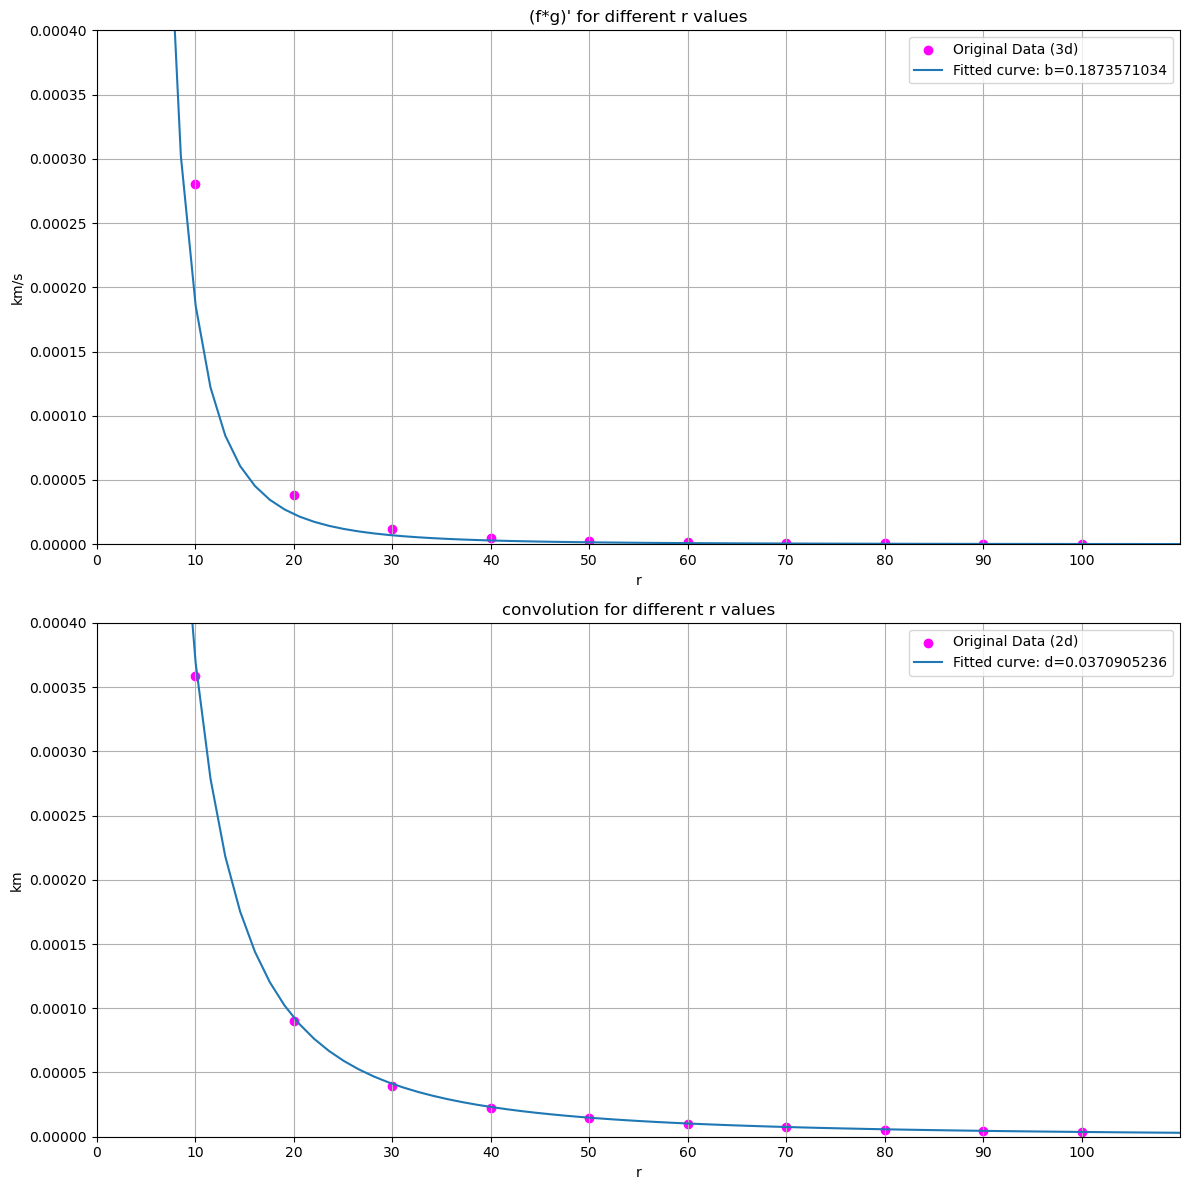

In [213]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
#r_values_dense = np.linspace(min(r_values), max(r_values), 100)  # 密なxの範囲を生成
r_values_dense = np.linspace(1, 150, 100)

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()

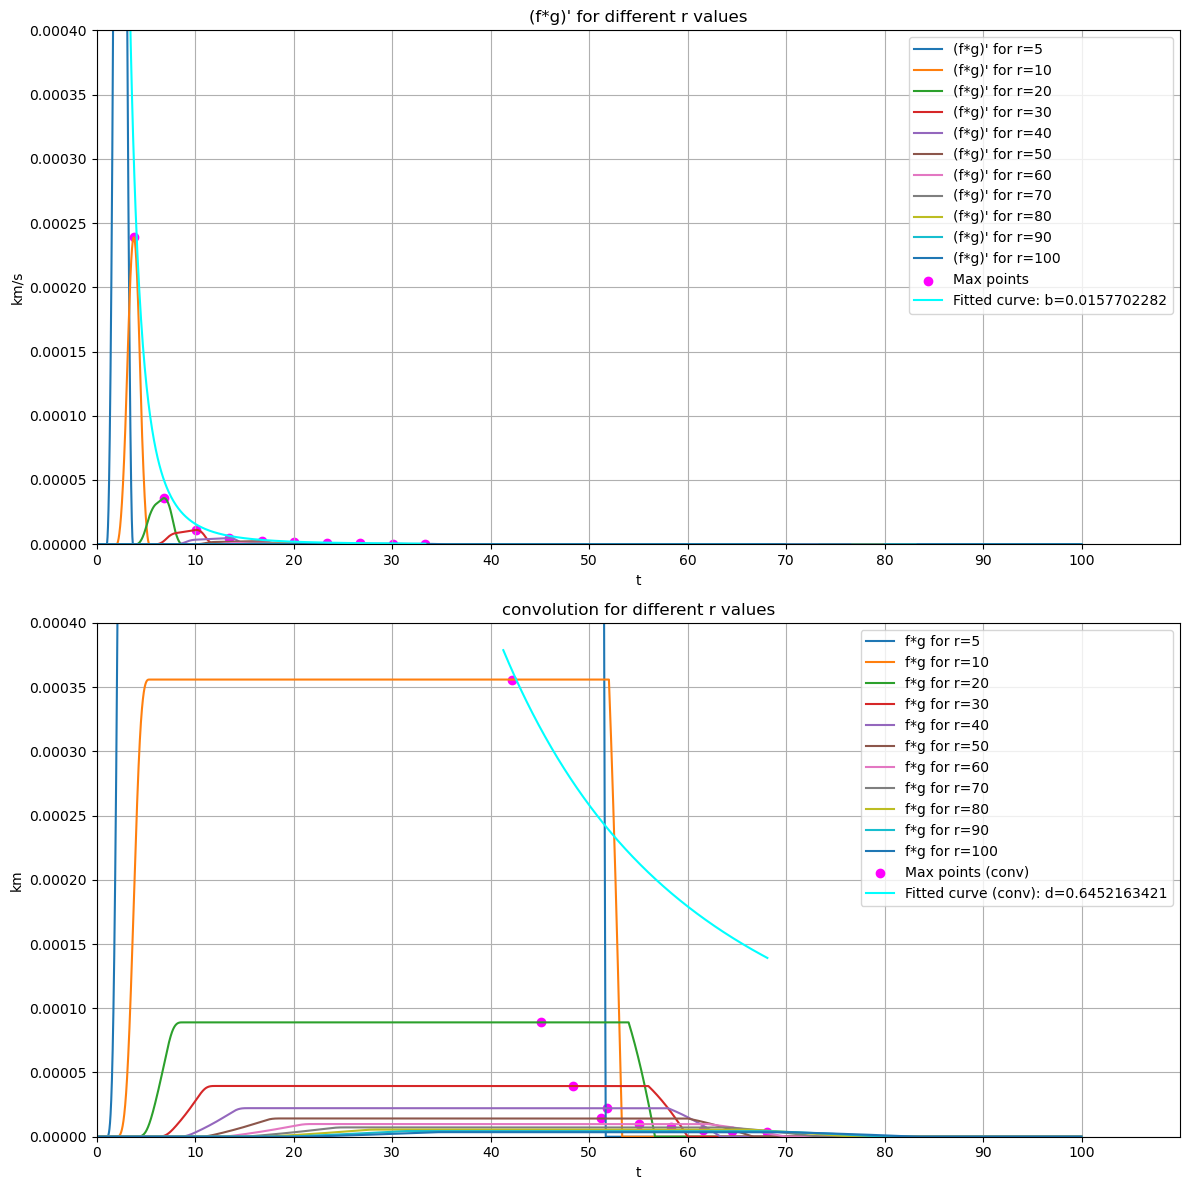

In [153]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [5,10, 20,30,40, 50, 60,70,80,90,100]

def sgn(x):
    return np.sign(x)

# 畳み込む関数
def f(t):
    return 1/8 * (2 + 4*t - (6 - 4*t + t**2) * sgn(2 - t) + t**2 * sgn(t) + sgn(1 - t) * (2 * (-1 + t)**2 + (2 - 4*t + t**2) * sgn(2 - t) + t**2 * sgn(t)))

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 50, 10000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2


params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()


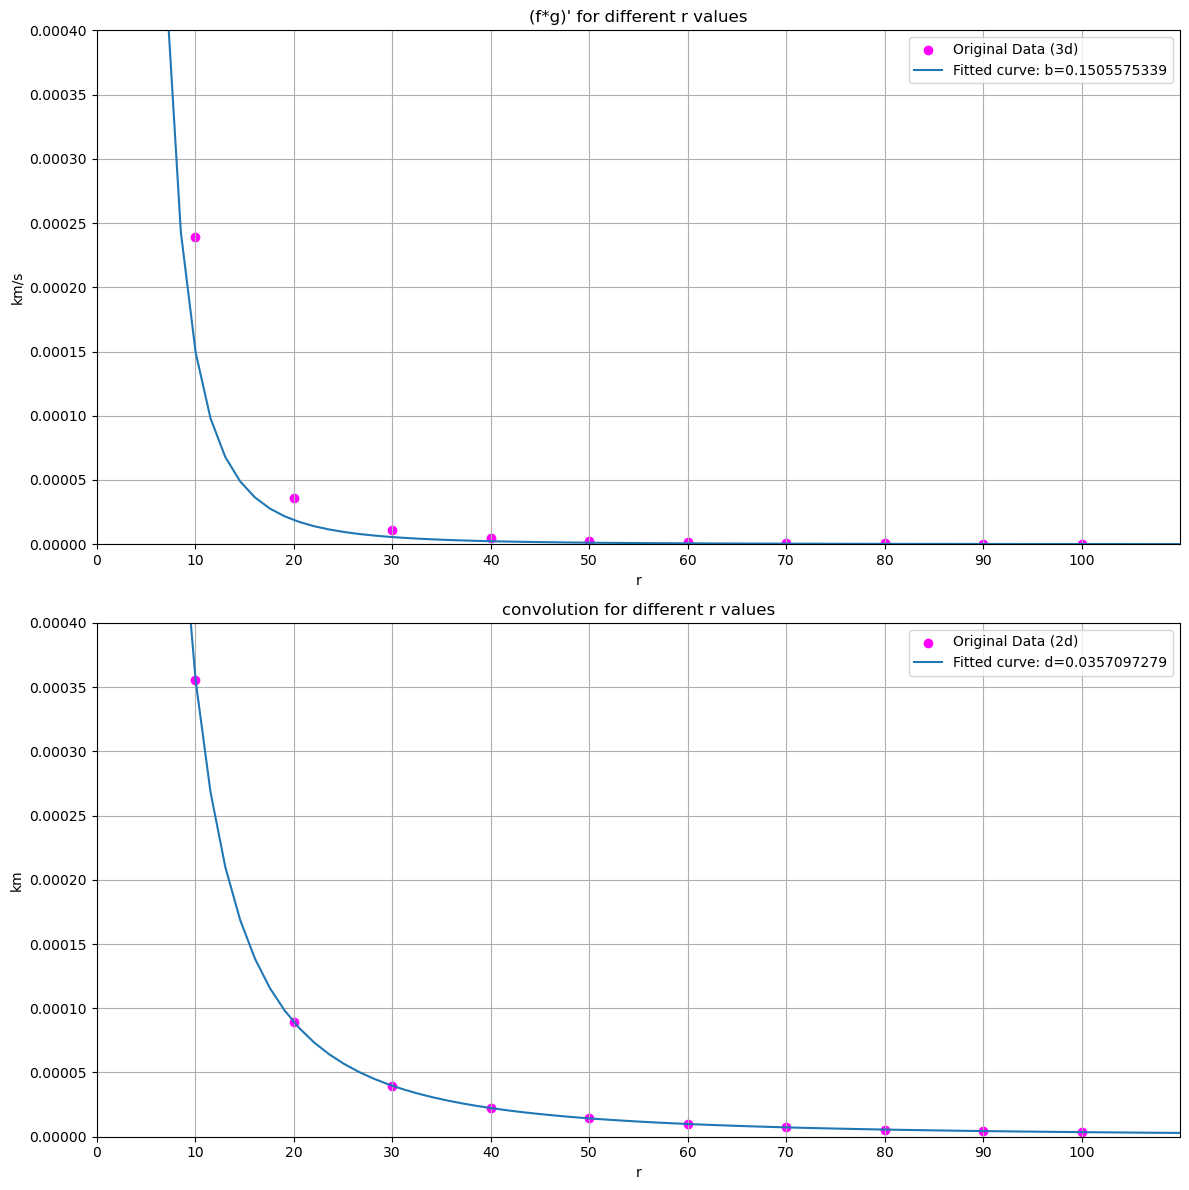

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
#r_values_dense = np.linspace(min(r_values), max(r_values), 100)  # 密なxの範囲を生成
r_values_dense = np.linspace(1, 150, 100)

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()

### 実験

In [80]:
import numpy as np

def linspace_with_special_points(range_min, range_max, num_points, special_points):
    base_linspace = np.linspace(range_min, range_max, num_points)
    all_points = np.unique(np.concatenate([base_linspace, special_points]))
    return np.sort(all_points)

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 特別な点
special_points = [r / alpha for r in r_values] + [r / beta for r in r_values]

# (r/alpha + r/beta) / 2 を追加
special_points += [(r / alpha + r / beta) / 2 for r in r_values]

# 新しいtの配列
t_new = linspace_with_special_points(0, 50, 1000, special_points)

In [66]:
for i, n in enumerate(t_new):
    if(n == 2.0):
        print(i)
    elif(n == 4.0):
        print(i)
    elif(n == (20 / 5 + 20 / 3) / 2):
        print(i)

40
83
111


In [67]:
special_points

[2.0,
 4.0,
 10.0,
 20.0,
 3.3333333333333335,
 6.666666666666667,
 16.666666666666668,
 33.333333333333336,
 2.666666666666667,
 5.333333333333334,
 13.333333333333334,
 26.666666666666668]

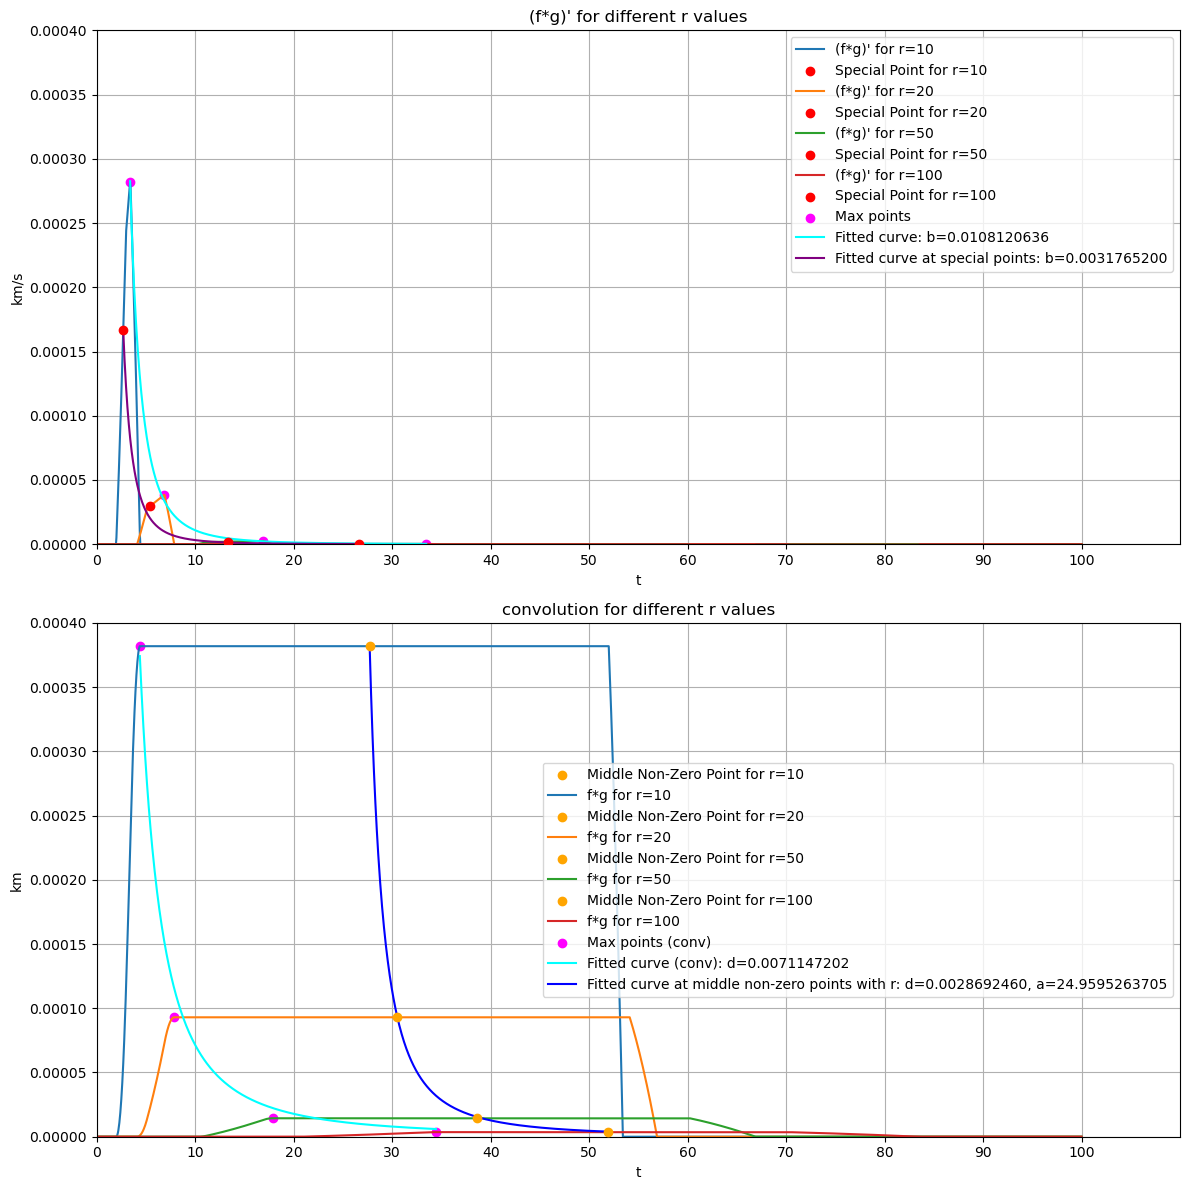

In [124]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# すべてのr値に対する中央の非ゼロ点をプロットする関数
def highlight_all_middle_non_zero(ax, t_values, all_data, r_values):
    for data, r in zip(all_data, r_values):
        non_zero_indices = np.nonzero(data)[0]
        if len(non_zero_indices) > 0:
            middle_index = non_zero_indices[len(non_zero_indices) // 2]
            ax.scatter(t_values[middle_index], data[middle_index], zorder=5, label=f'Middle Non-Zero Point for r={r}')

def linspace_with_special_points(range_min, range_max, num_points, special_points):
    base_linspace = np.linspace(range_min, range_max, num_points)
    all_points = np.unique(np.concatenate([base_linspace, special_points]))
    return np.sort(all_points)

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 特別な点
special_points = [r / alpha for r in r_values] + [r / beta for r in r_values]

# (r/alpha + r/beta) / 2 を追加
special_points += [(r / alpha + r / beta) / 2 for r in r_values]

# 新しいtの配列
t = linspace_with_special_points(0, 50, 1000, special_points)
dt = t[1] - t[0]


# 畳み込む関数
def f(t):
    result = np.zeros_like(t)
    mask1 = t < 1
    mask2 = t >= 1
    mask3 = t < 0
    result[mask1] = t[mask1]
    result[mask2] = 1
    result[mask3] = 0
    return result

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

# 中央の非ゼロ点を取得するためのリスト
middle_non_zero_t_values = []
middle_non_zero_values = []

# 特別な点での d_conv と conv の値を格納するリスト
special_d_conv_values = []
special_conv_values = []


# 特別な点 (r / alpha + r / beta) / 2 のインデックスを見つける
special_t_values = [(r / alpha + r / beta) / 2 for r in r_values]
special_indices = [np.argmin(np.abs(t_full - val)) for val in special_t_values]

for r, special_index in zip(r_values, special_indices):
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)
    
    # 特別な点での d_conv と conv の値を格納
    special_d_conv_values.append(d_conv[special_index])
    special_conv_values.append(conv[special_index])
    
    non_zero_indices = np.nonzero(conv)[0]
    if len(non_zero_indices) > 0:
        middle_index = non_zero_indices[len(non_zero_indices) // 2]
        middle_t_value = t_full[middle_index]
        middle_value = conv[middle_index]
        middle_non_zero_t_values.append(middle_t_value)
        middle_non_zero_values.append(middle_value)
        axs[1].scatter(middle_t_value, middle_value, color='orange', zorder=5, label=f'Middle Non-Zero Point for r={r}')

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")
    # 特別な点での d_conv と conv をマーク
    axs[0].scatter(t_full[special_index], d_conv[special_index], color='red', zorder=5, label=f'Special Point for r={r}')

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")
    
    

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# 特別な点での d_conv をフィット
params_d_conv, _ = curve_fit(func_3d, special_t_values, special_d_conv_values)
b_opt_d_conv = params_d_conv[0]
t_fit_d_conv = np.linspace(min(special_t_values), max(special_t_values), 500)
y_fit_d_conv = func_3d(t_fit_d_conv, b_opt_d_conv)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

def func_2d_r(t, d, a):
    return d / (t-a)**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# 中央の非ゼロ点でフィット
params_middle_r, _ = curve_fit(func_2d_r, middle_non_zero_t_values, middle_non_zero_values)
d_opt_middle_r, a_opt_middle_r = params_middle_r
t_fit_middle_r = np.linspace(min(middle_non_zero_t_values), max(middle_non_zero_t_values), 500)
y_fit_middle_r = func_2d_r(t_fit_middle_r, d_opt_middle_r, a_opt_middle_r)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
# 特別な点でのフィットをプロット
axs[0].plot(t_fit_d_conv, y_fit_d_conv, color='purple', label=f'Fitted curve at special points: b={b_opt_d_conv:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
# 中央の非ゼロ点でのフィットをプロット（新しい関数を使用）
axs[1].plot(t_fit_middle_r, y_fit_middle_r, color='blue', label=f'Fitted curve at middle non-zero points with r: d={d_opt_middle_r:.10f}, a={a_opt_middle_r:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()


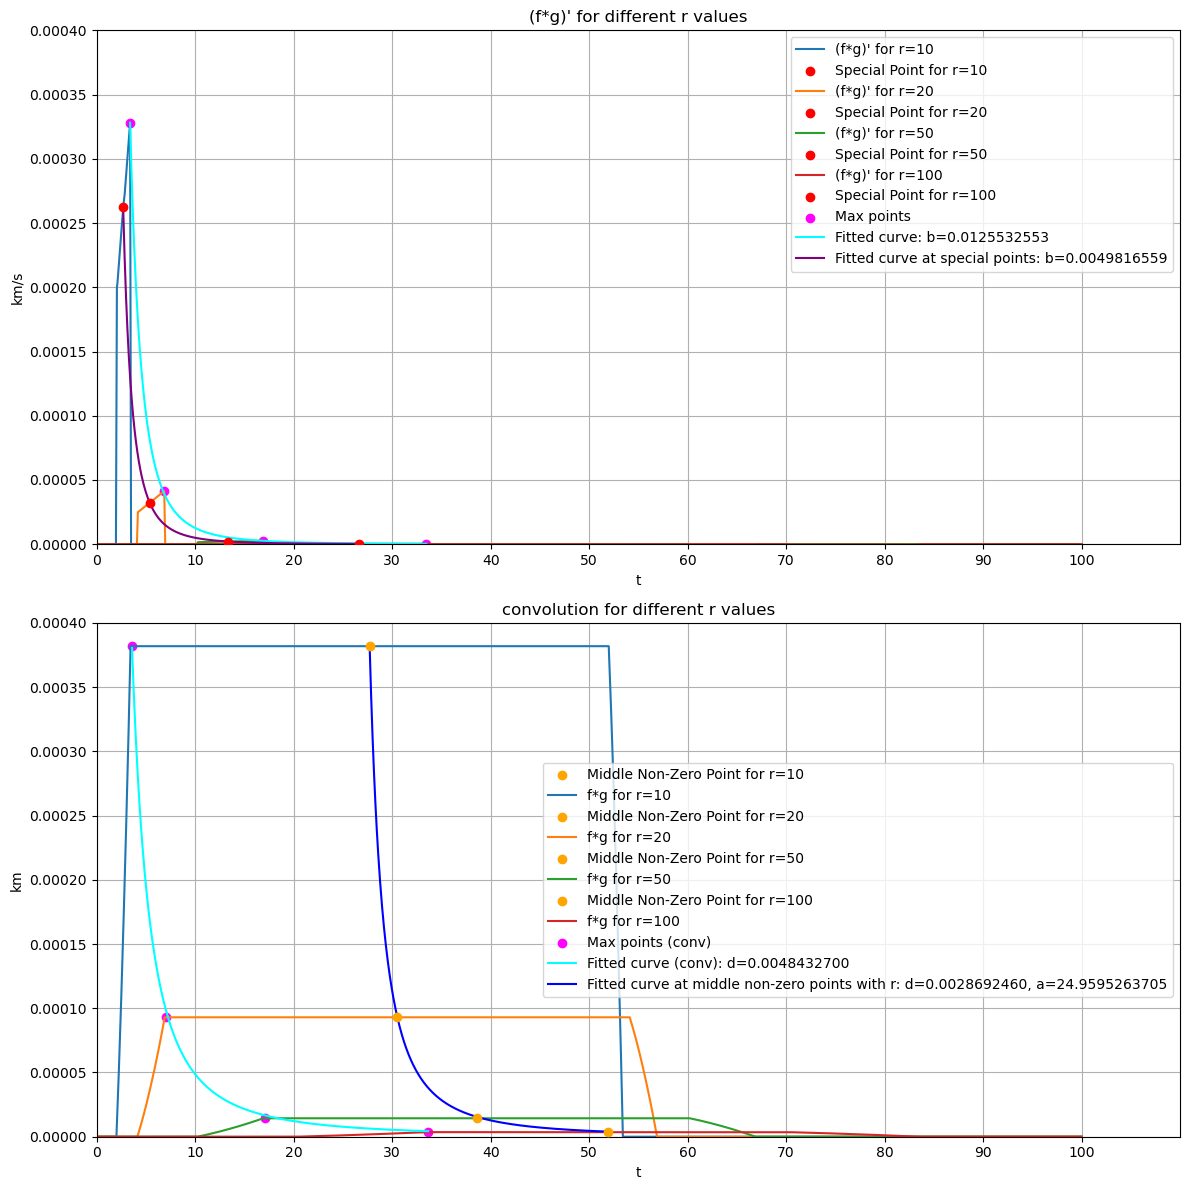

In [69]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# すべてのr値に対する中央の非ゼロ点をプロットする関数
def highlight_all_middle_non_zero(ax, t_values, all_data, r_values):
    for data, r in zip(all_data, r_values):
        non_zero_indices = np.nonzero(data)[0]
        if len(non_zero_indices) > 0:
            middle_index = non_zero_indices[len(non_zero_indices) // 2]
            ax.scatter(t_values[middle_index], data[middle_index], zorder=5, label=f'Middle Non-Zero Point for r={r}')

def linspace_with_special_points(range_min, range_max, num_points, special_points):
    base_linspace = np.linspace(range_min, range_max, num_points)
    all_points = np.unique(np.concatenate([base_linspace, special_points]))
    return np.sort(all_points)

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 特別な点
special_points = [r / alpha for r in r_values] + [r / beta for r in r_values]

# (r/alpha + r/beta) / 2 を追加
special_points += [(r / alpha + r / beta) / 2 for r in r_values]

# 新しいtの配列
t = linspace_with_special_points(0, 50, 1000, special_points)
dt = t[1] - t[0]


# 畳み込む関数
def f(t):
    return np.tanh(t/0.01)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

# 中央の非ゼロ点を取得するためのリスト
middle_non_zero_t_values = []
middle_non_zero_values = []

# 特別な点での d_conv と conv の値を格納するリスト
special_d_conv_values = []
special_conv_values = []


# 特別な点 (r / alpha + r / beta) / 2 のインデックスを見つける
special_t_values = [(r / alpha + r / beta) / 2 for r in r_values]
special_indices = [np.argmin(np.abs(t_full - val)) for val in special_t_values]

for r, special_index in zip(r_values, special_indices):
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)
    
    # 特別な点での d_conv と conv の値を格納
    special_d_conv_values.append(d_conv[special_index])
    special_conv_values.append(conv[special_index])
    
    non_zero_indices = np.nonzero(conv)[0]
    if len(non_zero_indices) > 0:
        middle_index = non_zero_indices[len(non_zero_indices) // 2]
        middle_t_value = t_full[middle_index]
        middle_value = conv[middle_index]
        middle_non_zero_t_values.append(middle_t_value)
        middle_non_zero_values.append(middle_value)
        axs[1].scatter(middle_t_value, middle_value, color='orange', zorder=5, label=f'Middle Non-Zero Point for r={r}')

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")
    # 特別な点での d_conv と conv をマーク
    axs[0].scatter(t_full[special_index], d_conv[special_index], color='red', zorder=5, label=f'Special Point for r={r}')

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")
    
    

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# 特別な点での d_conv をフィット
params_d_conv, _ = curve_fit(func_3d, special_t_values, special_d_conv_values)
b_opt_d_conv = params_d_conv[0]
t_fit_d_conv = np.linspace(min(special_t_values), max(special_t_values), 500)
y_fit_d_conv = func_3d(t_fit_d_conv, b_opt_d_conv)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

def func_2d_r(t, d, a):
    return d / (t-a)**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# 中央の非ゼロ点でフィット
params_middle_r, _ = curve_fit(func_2d_r, middle_non_zero_t_values, middle_non_zero_values)
d_opt_middle_r, a_opt_middle_r = params_middle_r
t_fit_middle_r = np.linspace(min(middle_non_zero_t_values), max(middle_non_zero_t_values), 500)
y_fit_middle_r = func_2d_r(t_fit_middle_r, d_opt_middle_r, a_opt_middle_r)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
# 特別な点でのフィットをプロット
axs[0].plot(t_fit_d_conv, y_fit_d_conv, color='purple', label=f'Fitted curve at special points: b={b_opt_d_conv:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
# 中央の非ゼロ点でのフィットをプロット（新しい関数を使用）
axs[1].plot(t_fit_middle_r, y_fit_middle_r, color='blue', label=f'Fitted curve at middle non-zero points with r: d={d_opt_middle_r:.10f}, a={a_opt_middle_r:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()


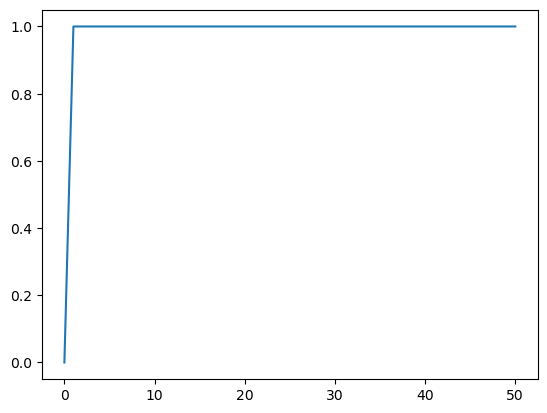

[0.         0.05005005 0.1001001  0.15015015 0.2002002  0.25025025
 0.3003003  0.35035035 0.4004004  0.45045045 0.5005005  0.55055055
 0.6006006  0.65065065 0.7007007  0.75075075 0.8008008  0.85085085
 0.9009009  0.95095095 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.       

In [104]:
# 畳み込む関数
def f(t):
    result = np.zeros_like(t)
    mask1 = (0 <= t) & (t < 1)
    mask2 = t >= 1
    result[mask1] = t[mask1]
    result[mask2] = 1
    return result

t = np.linspace(0, 50, 1000)

plt.plot(t, f(t))
plt.show()
print(f(t))

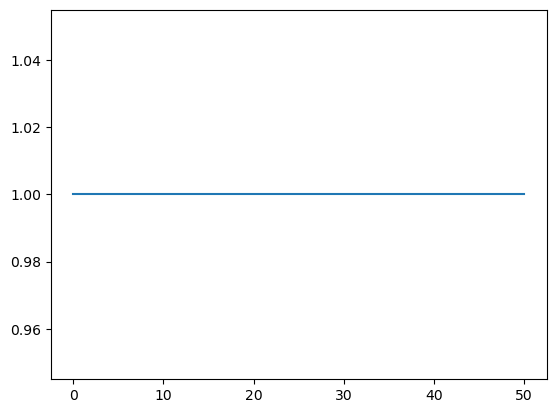

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [103]:
# 畳み込む関数
def f(t):
    return np.heaviside(t, 1)

t = np.linspace(0, 50, 1000)

plt.plot(t, f(t))
plt.show()
print(f(t))

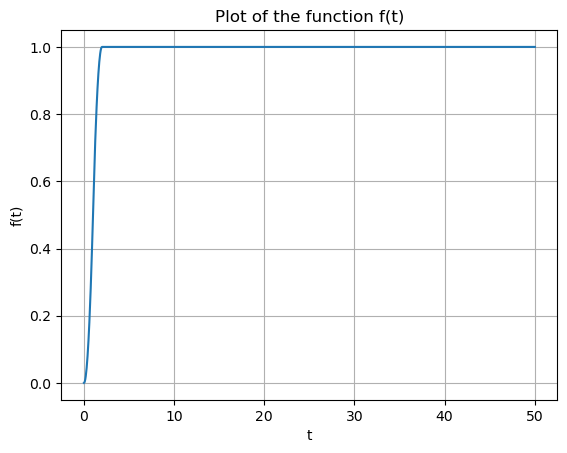

In [137]:
import numpy as np
import matplotlib.pyplot as plt

def sgn(x):
    return np.sign(x)

def f(t):
    return 1/8 * (2 + 4*t - (6 - 4*t + t**2) * sgn(2 - t) + t**2 * sgn(t) + sgn(1 - t) * (2 * (-1 + t)**2 + (2 - 4*t + t**2) * sgn(2 - t) + t**2 * sgn(t)))

t_values = np.linspace(0, 50, 1000)
y_values = f(t_values)

plt.plot(t_values, y_values)
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('Plot of the function f(t)')
plt.grid(True)
plt.show()


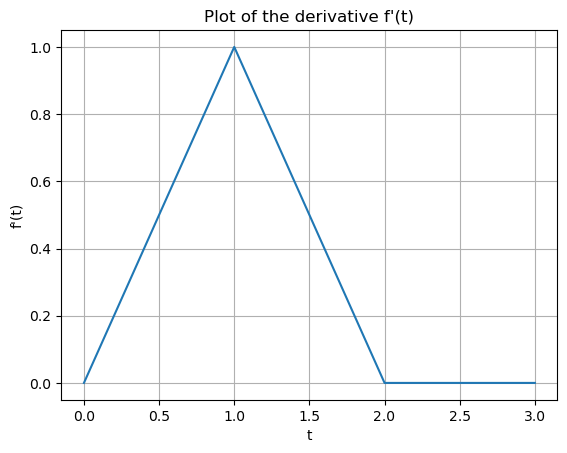

In [138]:
import numpy as np
import matplotlib.pyplot as plt

def sgn(x):
    return np.sign(x)

def f_prime(t):
    delta = 1e-5  # デルタ関数の近似幅
    delta_func = lambda x: np.exp(-x**2 / (2 * delta**2)) / (delta * np.sqrt(2 * np.pi))
    return 1/8 * (4 - (-4 + 2*t) * sgn(2 - t) + 2*t * sgn(t) - delta_func(1 - t) * (2 * (-1 + t)**2 + (2 - 4*t + t**2) * sgn(2 - t) + t**2 * sgn(t)) + delta_func(2 - t) * (6 - 4*t + t**2) + delta_func(t) * t**2 + sgn(1 - t) * (4 * (-1 + t) + (-4 + 2*t) * sgn(2 - t) + 2*t * sgn(t) - delta_func(2 - t) * (2 - 4*t + t**2) + delta_func(t) * t**2))

t_values = np.linspace(0, 3, 1000)
y_values_prime = f_prime(t_values)

plt.plot(t_values, y_values_prime)
plt.xlabel('t')
plt.ylabel("f'(t)")
plt.title("Plot of the derivative f'(t)")
plt.grid(True)
plt.show()


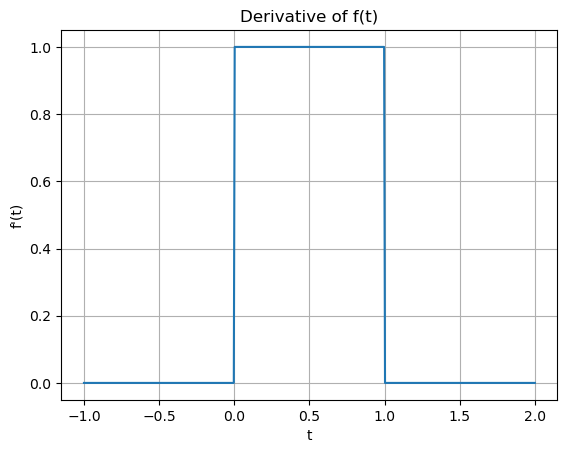

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# tの範囲とステップサイズを定義
t_values = np.linspace(-1, 2, 1000)
dt = t_values[1] - t_values[0]

# f(t)を定義
def f(t):
    result = np.zeros_like(t)
    mask1 = (0 <= t) & (t < 1)
    mask2 = t >= 1
    result[mask1] = t[mask1]
    result[mask2] = 1
    return result

# f(t)の微分を計算
f_prime = np.gradient(f(t_values), dt)

# グラフを描画
plt.plot(t_values, f_prime)
plt.xlabel('t')
plt.ylabel("f'(t)")
plt.title("Derivative of f(t)")
plt.grid(True)
plt.show()


/var/folders/58/_f3bywg95116dv_3jb9q54840000gn/T/ipykernel_7015/1279496418.py:38: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  g_prime = misc.derivative(lambda x: g(x, r), t, dx=dt)


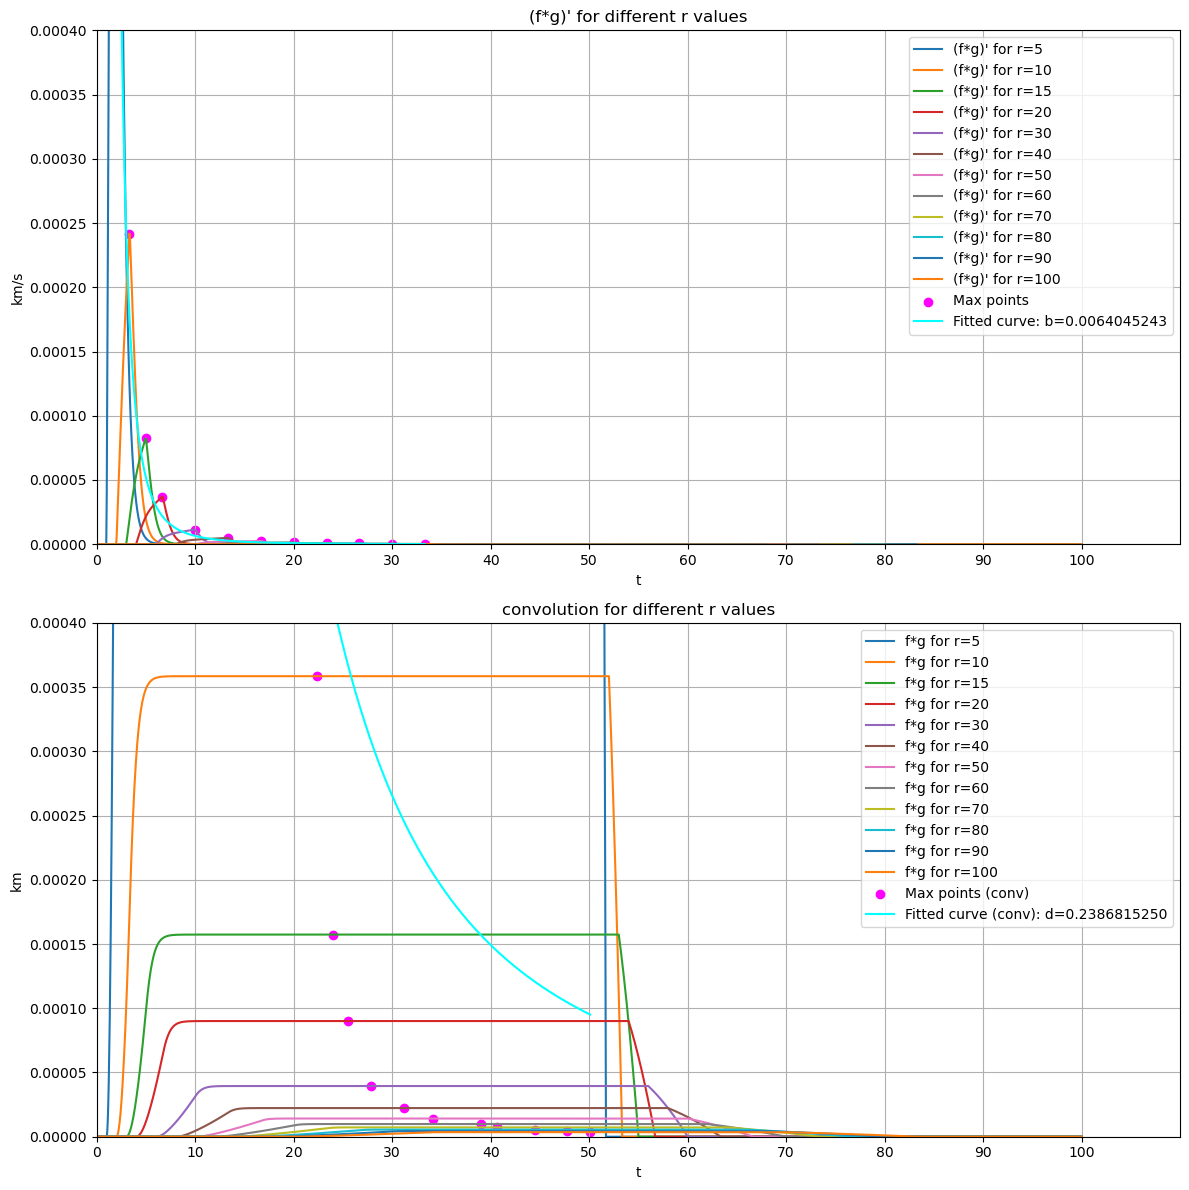

In [200]:
import numpy as np
from scipy import signal, misc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# 畳み込む関数
def f(t):
    return np.tanh(t)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # g'を計算
    g_prime = misc.derivative(lambda x: g(x, r), t, dx=dt)
    
    # f * g' 畳み込み
    d_conv = signal.convolve(f(t), g_prime, mode='full') * dt

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)

    # 変位の最大値とそうなるtを得る
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_ylim([0, 0.0004])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()


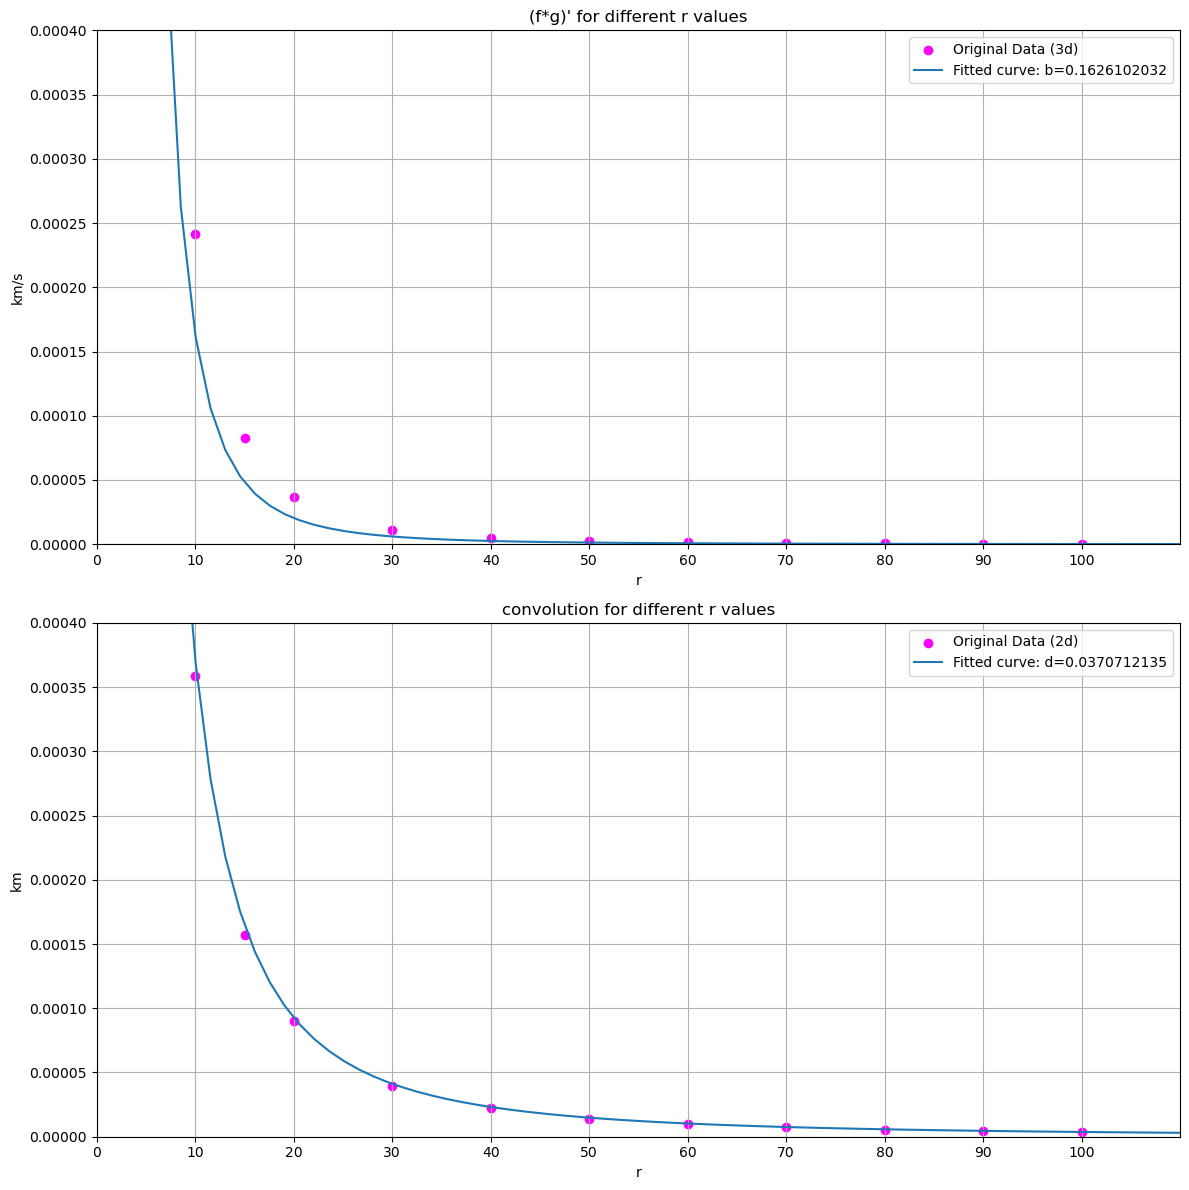

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
#r_values_dense = np.linspace(min(r_values), max(r_values), 100)  # 密なxの範囲を生成
r_values_dense = np.linspace(1, 150, 100)

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 110])
    ax.set_xticks(np.arange(0, 110, 10))

plt.tight_layout()
plt.show()

/var/folders/58/_f3bywg95116dv_3jb9q54840000gn/T/ipykernel_7015/1034869921.py:22: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d_func = derivative(func, t, dx=dt)


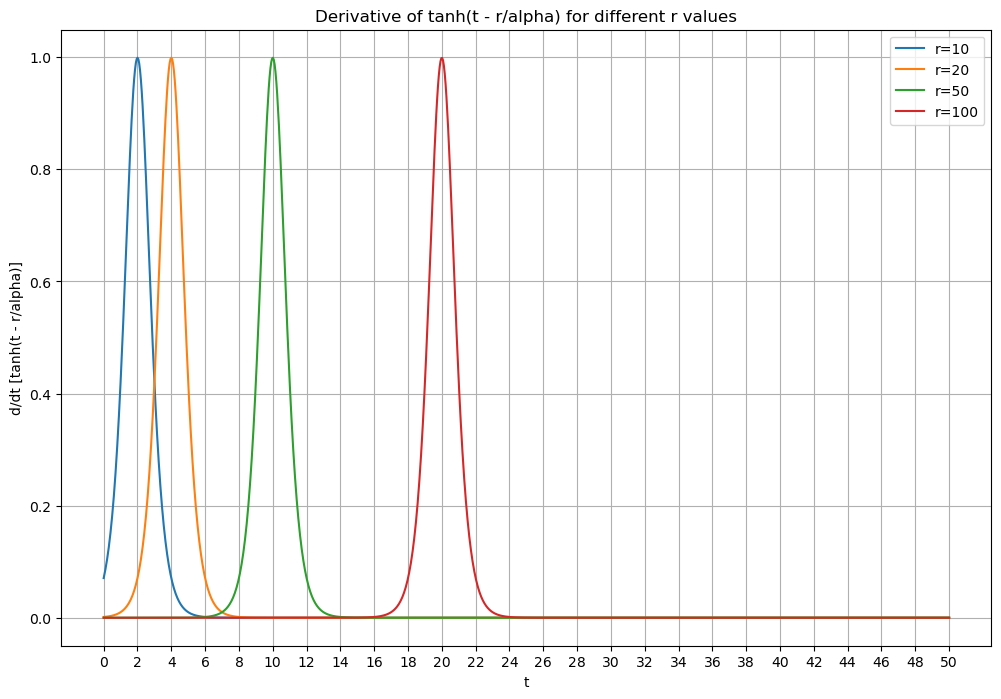

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

# パラメータ
alpha = 5
r_values = [10, 20, 50, 100]

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# プロット設定
plt.figure(figsize=(12, 8))

# 各r値で微分を計算してプロット
for r in r_values:
    # 微分の計算
    def func(t):
        return np.tanh(t - r / alpha)
    
    d_func = derivative(func, t, dx=dt)
    
    # プロット
    plt.plot(t, d_func, label=f"r={r}")

# グラフ設定
plt.title("Derivative of tanh(t - r/alpha) for different r values")
plt.xlabel("t")
plt.ylabel("d/dt [tanh(t - r/alpha)]")
# x軸を5刻みに設定
plt.xticks(np.arange(min(t), max(t) + 1, 2))
plt.legend()
plt.grid(True)

plt.show()


/var/folders/58/_f3bywg95116dv_3jb9q54840000gn/T/ipykernel_7015/3391487061.py:22: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d_func = derivative(func, t, dx=dt)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


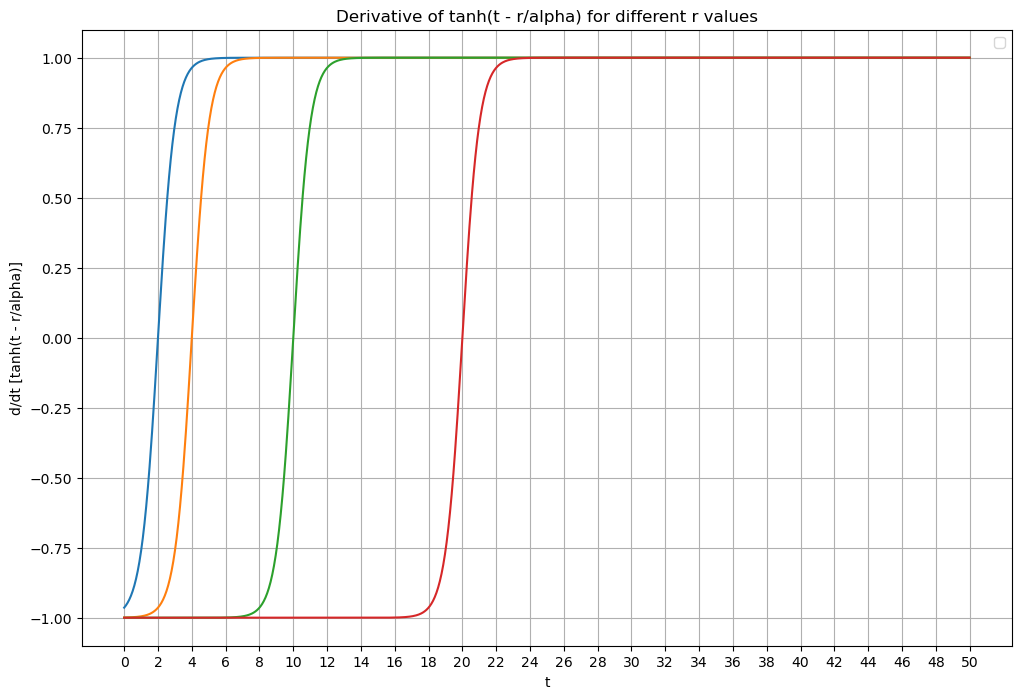

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

# パラメータ
alpha = 5
r_values = [10, 20, 50, 100]

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# プロット設定
plt.figure(figsize=(12, 8))

# 各r値で微分を計算してプロット
for r in r_values:
    # 微分の計算
    def func(t):
        return np.tanh(t - r / alpha)
    
    d_func = derivative(func, t, dx=dt)
    
    # プロット
    plt.plot(t, func(t))

# グラフ設定
plt.title("Derivative of tanh(t - r/alpha) for different r values")
plt.xlabel("t")
plt.ylabel("d/dt [tanh(t - r/alpha)]")
# x軸を5刻みに設定
plt.xticks(np.arange(min(t), max(t) + 1, 2))
plt.legend()
plt.grid(True)

plt.show()


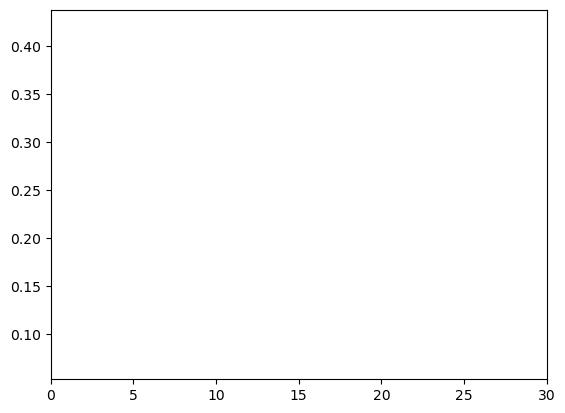

In [240]:
import numpy as np
import matplotlib.pyplot as plt

def func(t):
    return 1/(np.cosh(t - 1))**2

def func_2(t):
    return 1/(np.cosh(2*(t - 1)))**2

t = np.linspace(0, 30,1)

plt.plot(t, func(t), label="func1")
plt.plot(t, func_2(t), label="func_2")
plt.xlim([0,30])

plt.show()